# **📌 Import**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
# from sklearn.naive_bayes import 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from wordcloud import WordCloud

from tqdm import tqdm
import warnings
import sys
warnings.filterwarnings('ignore')
# Thiết lập style cho matplotlib
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
sklearn.set_config(enable_metadata_routing=True)

In [2]:
sys.path.append("..")
from modules import tabular
import importlib

# **📥 Download Dataset**

In [3]:
import kagglehub
import os
import shutil

data_dir = "../data/emotion_detection/"
raw_data_dir = os.path.join(data_dir, "raw_data/")
data_file_name = "tweet_emotions.csv"
features_dir = os.path.join(data_dir, "features/")
model_result_path = os.path.join(data_dir, "model_result/")

In [4]:
os.makedirs(data_dir, exist_ok=True)
os.makedirs(features_dir, exist_ok=True)


if os.path.exists(os.path.join(raw_data_dir, data_file_name)):
    print("Data file exists.")
else:
    path = kagglehub.dataset_download(
        handle="pashupatigupta/emotion-detection-from-text"
    )
    src = os.path.join(path, data_file_name)
    os.makedirs(raw_data_dir, exist_ok=True)
    shutil.copy(src, raw_data_dir)

print("Path to data:", os.path.join(raw_data_dir, data_file_name))

Data file exists.
Path to data: ../data/emotion_detection/raw_data/tweet_emotions.csv


In [5]:
df = pd.read_csv(os.path.join(raw_data_dir, data_file_name))
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


# **📊 EDA**

In [6]:
tabular.dataset_info(df=df)


Dataset Info:
Total samples: 40,000
Features: 3
Data Shape: (40000, 3)
Columns: Index(['tweet_id', 'sentiment', 'content'], dtype='object')
Dtypes:
 tweet_id      int64
sentiment    object
content      object
dtype: object


In [7]:
tabular.missing_report(df)

Missing Value:
           Missing  Percent
tweet_id         0      0.0
sentiment        0      0.0
content          0      0.0


In [8]:
tabular.column_report(df)

Column Report:
           Dtypes  Nunique
tweet_id    int64    40000
sentiment  object       13
content    object    39827


In [9]:
df = df.drop_duplicates(subset=["content"])
df = df.drop(columns=["tweet_id"])

In [10]:
df["text_len"] = df["content"].apply(func=lambda x: len(x))
df

,sentiment,content,text_len
0,empty,@tiffanylue i know i was listenin to bad habi...,92
1,sadness,Layin n bed with a headache ughhhh...waitin o...,60
2,sadness,Funeral ceremony...gloomy friday...,35
3,enthusiasm,wants to hang out with friends SOON!,36
4,neutral,@dannycastillo We want to trade with someone w...,86
...,...,...,...
39995,neutral,@JohnLloydTaylor,16
39996,love,Happy Mothers Day All my love,30
39997,love,Happy Mother's Day to all the mommies out ther...,123
39998,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...,122


In [11]:
_, text_len_report = tabular.numeric_stat_report(df)
text_len_report

,text_len
count,39827.000000
mean,73.530821
std,36.490448
min,1.000000
25%,43.000000
50%,69.000000
75%,103.000000
max,167.000000


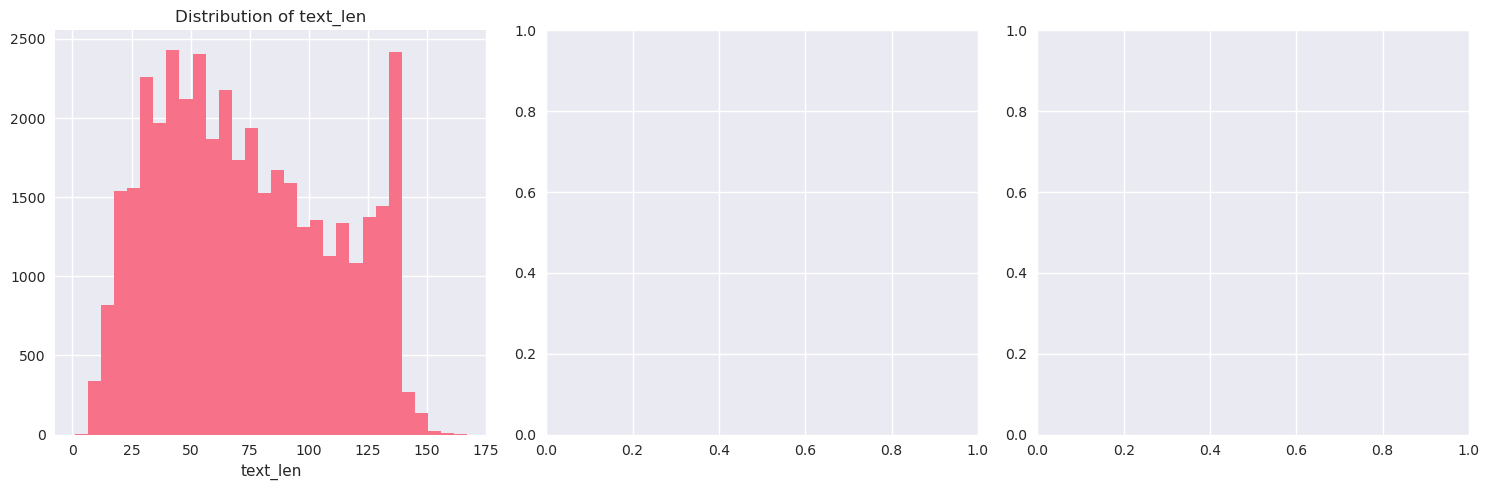

In [12]:
tabular.numeric_plot(df=df, config=None, plot="histogram")

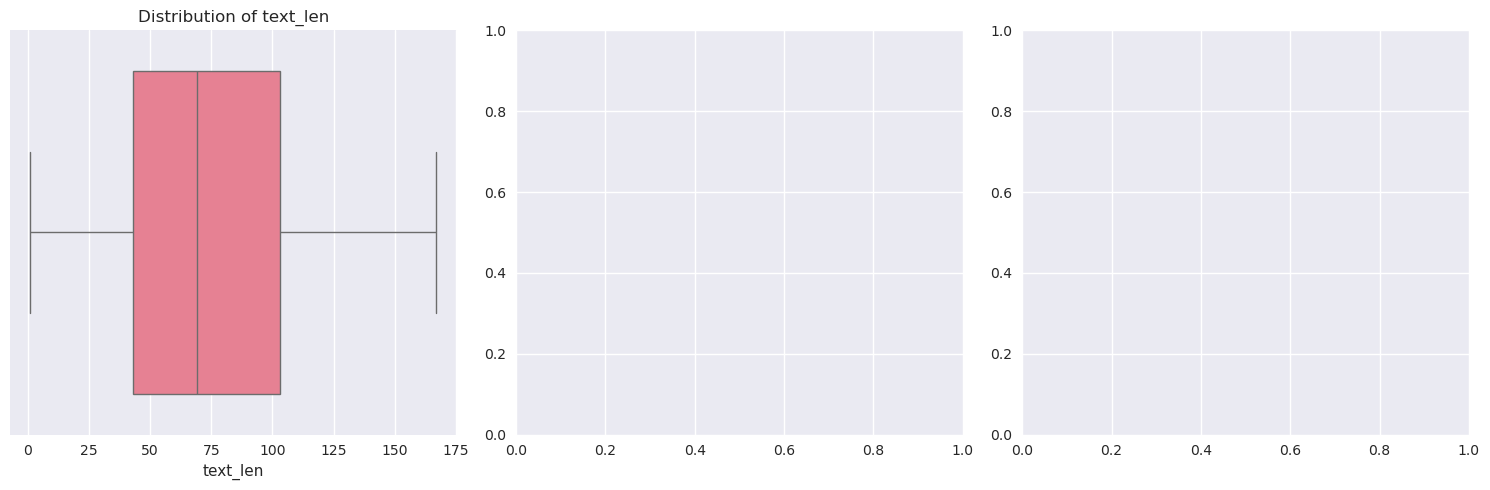

In [13]:
tabular.numeric_plot(df=df, config=None, plot="boxplot")

In [14]:
# Bag of words thô
def normal_bow(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    return text.split()

counter = Counter()
for text in df["content"]:
    counter.update(normal_bow(text))

In [15]:
normal_bow_df = pd.DataFrame(counter.items(), columns=["word", "count"])
normal_bow_df.sort_values("count", ascending=False)

,word,count
1,i,18980
5,to,14329
101,the,12847
19,a,9613
54,my,7972
...,...,...
53597,consummate,1
53596,frolic,1
53595,iscreamshinki,1
53594,astronick,1


In [16]:
print("Rare words (count = 1):", sum(normal_bow_df["count"] == 1))

Rare words (count = 1): 38706


In [17]:
def count_special(text):
    special_key = re.findall(r"[^\w\s,]", text) # Not a-z, 0-9, _, space, ","
    mentions = re.findall(r"@\w+", text)
    hashtags = re.findall(r"#\w+", text)
    links = re.findall(r"http\S+", text)
    return len(special_key), len(mentions), len(hashtags), len(links)

df[["special_count", "mention_count", "hashtag_count", "link_count"]] = df["content"].apply(
    lambda x: pd.Series(count_special(x))
)

print("Special key count:", df["special_count"].sum())
print("Mention (@) count:", df["mention_count"].sum())
print("Hashtag (#) count:", df["hashtag_count"].sum())
print("Link count:", df["link_count"].sum())

Special key count: 144828
Mention (@) count: 19991
Hashtag (#) count: 920
Link count: 1804


In [18]:
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /home/nhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
def advanced_bow(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)   # xóa link
    text = re.sub(r"@\w+|#\w+", "", text)                 # xóa hashtag, mention
    text = re.sub(r"[^a-z\s]", "", text)                  
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    return tokens

df["tokens"] = df["content"].apply(advanced_bow)

In [20]:
df

,sentiment,content,text_len,special_count,mention_count,hashtag_count,link_count,tokens
0,empty,@tiffanylue i know i was listenin to bad habi...,92,3,1,0,0,"[know, listenin, bad, habit, earlier, started,..."
1,sadness,Layin n bed with a headache ughhhh...waitin o...,60,6,0,0,0,"[layin, n, bed, headache, ughhhhwaitin, call]"
2,sadness,Funeral ceremony...gloomy friday...,35,6,0,0,0,"[funeral, ceremonygloomy, friday]"
3,enthusiasm,wants to hang out with friends SOON!,36,1,0,0,0,"[wants, hang, friends, soon]"
4,neutral,@dannycastillo We want to trade with someone w...,86,2,1,0,0,"[want, trade, someone, houston, tickets, one]"
...,...,...,...,...,...,...,...,...
39995,neutral,@JohnLloydTaylor,16,1,1,0,0,[]
39996,love,Happy Mothers Day All my love,30,0,0,0,0,"[happy, mothers, day, love]"
39997,love,Happy Mother's Day to all the mommies out ther...,123,5,0,0,0,"[happy, mothers, day, mommies, woman, man, lon..."
39998,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...,122,12,1,0,0,"[wassup, beautiful, follow, peep, new, hit, si..."


In [21]:
all_tokens = [t for doc in df["tokens"] for t in doc]
word_freq = Counter(all_tokens)

advanced_bow_df = pd.DataFrame(word_freq.items(), columns=["word", "count"])
advanced_bow_df.sort_values("count", ascending=False)

,word,count
35,im,4407
204,day,2990
291,good,2243
59,get,1999
33,like,1928
...,...,...
33783,quotghosts,1
33784,goooodnight,1
33785,kingdomquot,1
33786,ayehe,1


In [22]:
print("Rare words (count = 1):", sum(advanced_bow_df["count"] == 1))

Rare words (count = 1): 21351


EDA Label

Phân bố Label:
sentiment
neutral       8598
worry         8437
happiness     5184
sadness       5154
love          3785
surprise      2181
fun           1775
relief        1522
hate          1322
empty          822
enthusiasm     758
boredom        179
anger          110
Name: count, dtype: int64


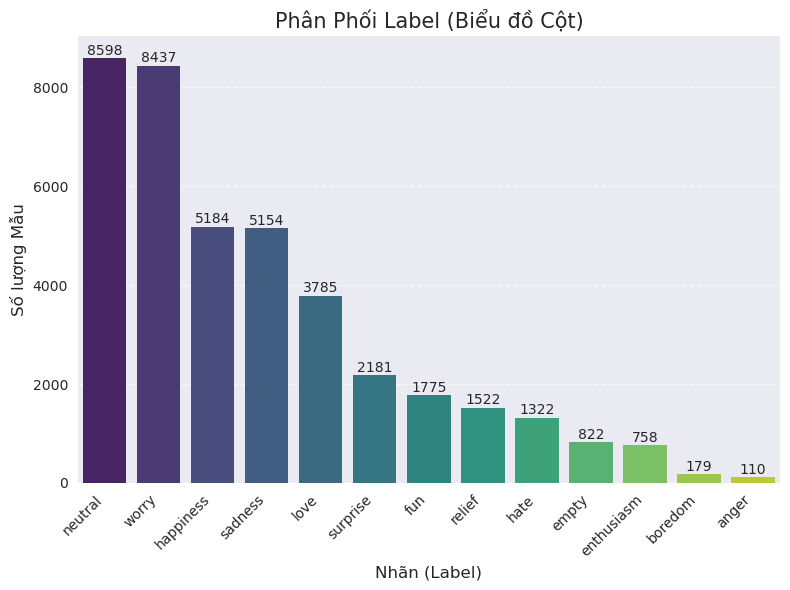

In [26]:
label_counts = df["sentiment"].value_counts()
print("Phân bố Label:")
print(label_counts)

# ----------------------------------------------------------------------
## 3. Vẽ biểu đồ Cột (Bar Plot) - Cách phổ biến nhất
# ----------------------------------------------------------------------
plt.figure(figsize=(8, 6))
# Sử dụng Seaborn để vẽ biểu đồ cột cho các giá trị đã đếm
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")

plt.title('Phân Phối Label (Biểu đồ Cột)', fontsize=15)
plt.xlabel('Nhãn (Label)', fontsize=12)
plt.ylabel('Số lượng Mẫu', fontsize=12)
plt.xticks(rotation=45, ha='right') # Xoay tên nhãn nếu dài
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Thêm số lượng lên trên mỗi cột
for i, v in enumerate(label_counts.values):
    plt.text(i, v + 5, str(v), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# **Preprocessing**

In [27]:
X = df["content"]
y = df["sentiment"]

In [28]:
from typing import List, Optional
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

nltk.download('punkt')
# nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /home/nhan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nhan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [29]:
def text_preprocess(
    df,
    lowercase=True,
    tokenizer="split",
    remove_stopwords=True,
    lemmatize=False,
    join_space=True
):
    def preprocess_single(text):
        if lowercase:
            text = text.lower()
        text = re.sub(r"http\S+|www\S+|https\S+", "", text)
        text = re.sub(r"@\w+|#\w+", "", text)
        text = re.sub(r"[^a-z\s]", "", text)

        if tokenizer == "split":
            tokens = text.split()
        elif tokenizer == "nltk":
            tokens = word_tokenize(text)
        else:
            raise ValueError("Unknown tokenizer, use 'split' or 'nltk'")
        
        if remove_stopwords:
            tokens = [t for t in tokens if t not in stop_words]
        if lemmatize:
            tokens = [lemmatizer_tool(t) for t in tokens]
        
        if join_space:
            return " ".join(tokens)
        else:
            return tokens
    
    stop_words = set(stopwords.words("english"))
    lemmatizer_tool = WordNetLemmatizer()

    return [preprocess_single(text) for text in df]

In [30]:
X_clean = text_preprocess(X)
X_clean

['know listenin bad habit earlier started freakin part',
 'layin n bed headache ughhhhwaitin call',
 'funeral ceremonygloomy friday',
 'wants hang friends soon',
 'want trade someone houston tickets one',
 'repinging didnt go prom bc bf didnt like friends',
 'sleep im thinking old friend want hes married damn amp wants scandalous',
 'hmmm',
 'charlene love miss',
 'im sorry least friday',
 'cant fall asleep',
 'choked retainers',
 'ugh beat stupid song get next rude',
 'u watch hills london u realise tourture weeks weeks late watch itonlinelol',
 'got news',
 'storm electricity gone',
 'agreed',
 'sleepy even late fail',
 'lady gaga tweeted impressed video leaking know',
 'convinced always wanted signals give offdamn think lost another friend',
 'oh bad hope gets better ive sleep issues lately',
 'wondering im awake amwriting new songplotting evil secret plots muahahahaoh damn itnot secret anymore',
 'topic maps talks balisage markup conference program online via',
 'ate something dont

In [31]:
target_encoder = OrdinalEncoder()
y_clean = target_encoder.fit_transform(y.values.reshape(-1, 1))
y_clean

array([[ 2.],
       [10.],
       [10.],
       ...,
       [ 7.],
       [ 5.],
       [ 7.]], shape=(39827, 1))

# **Train & Test split**

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42, stratify=y)

In [33]:
X_train

['woot interview went awsome didnt get talk mr johnny thought oh well still really good',
 'jimithy cant come msbjlt',
 'couple days sheeeeit wish something cafe claude',
 'people following people follow please x',
 'wanted go clubdancingbut im tired anyways go work tomorrow',
 'saw tour months ago boston good glad finally got see',
 'revise bit back soon',
 'hates sat around alone friday night big sad old loser',
 'awww daddy got car accident pray hes shookn lil',
 'hey handsome im packing',
 'dudes cmon thats almost ghey',
 'support trust honor moms support health happy moms day',
 'looks nice never knew vhs short life span hope fav vhs dead',
 'spanish suckiest class ever im learning atleast te quiero tiasha',
 'ahhh feel sorry little girl cant watch crying xx',
 'aww minutes left family guy',
 'ty much ff',
 'oh noes tv broken red standby light anything checked plug fuse inside',
 'wheres bridge need one fuck',
 'picnic table cruet set',
 'love fact bank holiday monday stay bed',
 

# **Feature Extraction**

In [34]:
class TextEmbedding(BaseEstimator, TransformerMixin):
    """
    Method:
        - 'bow'   : Bag of Words
        - 'tfidf' : TF-IDF
        - 'none'  : giữ nguyên token (cho deep learning)
    """
    def __init__(self, method: str = "tfidf", max_features: Optional[int] = 5000):
        self.method = method
        self.max_features = max_features

        if self.method == "bow":
            self.vectorizer = CountVectorizer(max_features=self.max_features)
        elif self.method == "tfidf":
            self.vectorizer = TfidfVectorizer(max_features=self.max_features)
        elif self.method != "none": # if "none" do nothing
            raise ValueError("method must be 'bow', 'tfidf', or 'none'")

    def fit(self, X: List[List[str]], y=None):
        # texts = [" ".join(tokens) for tokens in X] # rejoin for sklearn :v
        if self.method != "none":
            self.vectorizer.fit(X)
        return self

    def transform(self, X: List[List[str]]):
        # texts = [" ".join(tokens) for tokens in X]
        if self.method != "none":
            return self.vectorizer.transform(X).toarray()
        else:
            return X


In [35]:
class SequencePadder(BaseEstimator, TransformerMixin):
    """
    Padding độ dài chuỗi cho mô hình deep learning.
    """
    def __init__(self, max_len: int = 50, pad_token: str = "<PAD>"):
        self.max_len = max_len
        self.pad_token = pad_token

    def fit(self, X, y=None):
        return self

    def transform(self, X: List[List[str]]):
        padded = []
        for seq in X:
            if len(seq) > self.max_len:
                seq = seq[:self.max_len]
            else:
                seq = seq + [self.pad_token] * (self.max_len - len(seq))
            padded.append(seq)
        return np.array(padded)


In [ ]:
def build_text_pipeline(
    embedding="tfidf",
    max_feature=5000,
    use_padding=False,
    padding_max_len=50
):
    steps = [
        ("embed", TextEmbedding(method=embedding, max_features=max_feature))
    ]
    if use_padding:
        steps.append(("pad", SequencePadder(max_len=padding_max_len)))

    return Pipeline(steps)


In [37]:
pipe = build_text_pipeline()

In [ ]:
default_features_dir = os.path.join(features_dir, "default/")
os.makedirs(default_features_dir, exist_ok=True)

if not os.path.exists(os.path.join(default_features_dir, "train.npy")):
    X_train_features = pipe.fit_transform(X_train)
    np.save(os.path.join(default_features_dir, "train"), X_train_features)

if not os.path.exists(os.path.join(default_features_dir, "test.npy")):
    X_test_features = pipe.transform(X_test)
    np.save(os.path.join(default_features_dir, "test"),  X_test_features)

# print(f"X_train_features shape: {X_train_features.shape}, X_test_features shape: {X_test_features.shape}")

# **Train & Evaluate Model**


In [39]:
from sklearn.model_selection import ParameterGrid
# Model chosing
param_grid = [
    {
        "model": [LogisticRegression()],
    },
    {
        "model": [RandomForestClassifier(max_depth=100)],
    },
    # {
    #     "model": [SVC()], # Take too long to train
    # },
    {
        "model": [MLPClassifier()],
    },
    {
        "model": [MultinomialNB()]
    }
]
grid = ParameterGrid(param_grid=param_grid)

In [40]:
TRAIN = False # Multi train later

In [41]:
if TRAIN:
    results = []

    X_train = np.load(os.path.join(default_features_dir, "train.npy"))
    X_test = np.load(os.path.join(default_features_dir, "test.npy"))

    for params in grid:
        # Tạo pipeline với model tương ứng
        pipe = Pipeline([
            # ("preprocess", preprocessing_pipeline),
            ("model", params["model"])
        ])
        pipe.set_params(**params)
        pipe.set_output(transform="pandas")

        print(f"Training {params["model"].__class__.__name__}...")
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        pre = precision_score(y_test, y_pred, average="weighted")
        recall = recall_score(y_test, y_pred, average="weighted")
        f1  = f1_score(y_test, y_pred, average="weighted")

        # Lưu kết quả
        results.append({
            "Params": params["model"].__class__.__name__,
            "accuracy": acc,
            "precision": pre,
            "recall": recall,
            "f1": f1
        })
        print(results[-1])

    # Xuất kết quả ra DataFrame
    df_results = pd.DataFrame(results)
    print(df_results)

In [42]:
# os.makedirs(model_result_path, exist_ok=True)
# df_results.to_csv(os.path.join(model_result_path, "test"))

# **Autotrain model with multi config**

In [43]:
tfidf_max_features = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]

In [44]:
tfidf_pipe = [build_text_pipeline(embedding="tfidf", max_feature=i) for i in tfidf_max_features]

In [ ]:
for i, embedding in enumerate(tfidf_pipe):
    if os.path.exists(os.path.join(model_result_path, f"tfidf_max_features_{(i+1)*500}")):
        continue
    results = []

    X_train_config = embedding.fit_transform(X_train)
    X_test_config = embedding.transform(X_test)

    print(f"Training with tfidf max_features={(i+1)*500}")

    for params in grid:
        # Tạo pipeline với model tương ứng
        pipe = Pipeline([
            # ("preprocess", preprocessing_pipeline),
            ("model", params["model"])
        ])
        pipe.set_params(**params)
        pipe.set_output(transform="pandas")

        print(f"Training {params["model"].__class__.__name__}...")
        pipe.fit(X_train_config, y_train)
        y_pred = pipe.predict(X_test_config)

        acc = accuracy_score(y_test, y_pred)
        pre = precision_score(y_test, y_pred, average="weighted")
        recall = recall_score(y_test, y_pred, average="weighted")
        f1  = f1_score(y_test, y_pred, average="weighted")

        # Lưu kết quả
        results.append({
            "Params": params["model"].__class__.__name__,
            "accuracy": acc,
            "precision": pre,
            "recall": recall,
            "f1": f1
        })
        print(results[-1])

    # Xuất kết quả ra DataFrame
    df_results = pd.DataFrame(results)
    df_results.to_csv(os.path.join(model_result_path, f"tfidf_max_features_{(i+1)*500}.csv"))
    print(df_results)

In [46]:
# Print two best config results: 1500 and 2500 max_features
results_1500 = pd.read_csv(os.path.join(model_result_path, f"tfidf_max_features_1500.csv"))
results_2500 = pd.read_csv(os.path.join(model_result_path, f"tfidf_max_features_2500.csv"))

In [47]:
results_1500

,Unnamed: 0,Params,accuracy,precision,recall,f1
0,0,LogisticRegression,0.343836,0.320640,0.343836,0.309202
1,1,RandomForestClassifier,0.336932,0.313141,0.336932,0.299128
2,2,MLPClassifier,0.265001,0.256918,0.265001,0.259100
3,3,MultinomialNB,0.319734,0.375253,0.319734,0.270183


In [48]:
results_2500

,Unnamed: 0,Params,accuracy,precision,recall,f1
0,0,LogisticRegression,0.341828,0.321386,0.341828,0.307808
1,1,RandomForestClassifier,0.339192,0.320549,0.339192,0.300522
2,2,MLPClassifier,0.265629,0.257651,0.265629,0.260603
3,3,MultinomialNB,0.318479,0.274555,0.318479,0.267084
